In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
from funzioni import compute_dataset_weighted
from funzioni import compute_annual_mean_weighted
from funzioni import convert_dataset_celsius
from funzioni import compute_anomaly
from funzioni import create_djf_dataset
from funzioni import compute_mean_time_season
from funzioni import compute_mean_resample_mar
from funzioni import plot_bias_atmos
from funzioni import plot_bias_tos
from funzioni import plot_mean_cluster_atmos
from funzioni import plot_bias_2_models_atmos
from funzioni import plot_zonavg
from funzioni import plot_zonavg_2_cluster
from funzioni import plot_mean_cluster_zonavg
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import plotly.express as px
import dill
import pickle

Caricamento file pickle

In [2]:
with open('models_atmos.pkl','rb') as file:
    models_atmos = dill.load(file)
    era_na_seas_mean = dill.load(file)

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [3]:
with open('modelli_atmos.pickle', 'rb') as f:
    # Caricamento delle 5 liste contenenti i nomi dei modelli all'interno dei 5 cluster
    list_cluster0 = pickle.load(f)
    list_cluster1 = pickle.load(f)
    list_cluster2 = pickle.load(f)
    list_cluster3 = pickle.load(f)
    list_cluster4 = pickle.load(f)
    
    # Caricamento dei 5 cluster in formato pdf
    atmos_cluster0 = pickle.load(f)
    atmos_cluster1 = pickle.load(f)
    atmos_cluster2 = pickle.load(f)
    atmos_cluster3 = pickle.load(f)
    atmos_cluster4 = pickle.load(f)
    
    # Caricamento dei cluster medi in formato pdf
    atmos_cluster0_mean = pickle.load(f)
    atmos_cluster1_mean = pickle.load(f)
    atmos_cluster2_mean = pickle.load(f)
    atmos_cluster3_mean = pickle.load(f)
    atmos_cluster4_mean = pickle.load(f)

Medie zonali

In [4]:
# creo un dizionario in cui andrò a mettere tutti i modelli dentro
models_zonavg = {}

In [5]:
#Percorso dei file
name_models_zonavg = '/work/users/guest/sbeltrami/prova/zonal_mean_name_ok_model.txt'
path_models_zonavg = '/work/users/guest/sbeltrami/prova/path_zonal_mean_model.txt'
path_remap_models_zonavg = '/work/users/guest/sbeltrami/prova/path_remap_zonal_mean_model.txt'
path_zonal_model_models_zonavg = '/work/users/guest/sbeltrami/prova/path_zonavg_model.txt'
# Apro i 3 file in modalità di lettura
with open(name_models_zonavg, 'r') as file: #nome file
    # Leggo tutte le righe del file e salvo in una lista
    lines_name_models_zonavg = file.readlines()
with open(path_models_zonavg, 'r') as file: #percorso dei file .nc
    lines_path_models_zonavg = file.readlines()
with open(path_remap_models_zonavg, 'r') as file: #percorso dei file remap
    lines_path_remap_models_zonavg = file.readlines()
with open(path_zonal_model_models_zonavg, 'r') as file: #percorso dei file remap + zonavg
    lines_path_zonal_model_models_zonavg = file.readlines()

In [6]:
# Itero su tutte le righe dei 3 file e organizzo i dati nel dizionario
for line_name, line_path, line_path_remap, line_path_zonal_model in zip(lines_name_models_zonavg, lines_path_models_zonavg, lines_path_remap_models_zonavg,lines_path_zonal_model_models_zonavg): #zip per iterare sulle 3 liste contemporaneamente
    model_name = line_name.strip() #senza spazi bianchi
    #model_name è la chiave principale
    # Inizializzo il dizionario se non esiste ancora
    if model_name not in models_zonavg:
        models_zonavg[model_name] = {}
    # Aggiungo name, path, path remap come sottochiavi
    models_zonavg[model_name]['zonavg name'] = model_name
    models_zonavg[model_name]['zonavg path'] = line_path.strip()
    models_zonavg[model_name]['zonavg path remap'] = line_path_remap.strip()
    models_zonavg[model_name]['zonavg path remap zonal mean'] = line_path_zonal_model.strip()

In [7]:
models_zonavg.items()

dict_items([('TaiESM1', {'zonavg name': 'TaiESM1', 'zonavg path': '/work/users/guest/sbeltrami/zonal_mean/TaiESM1.nc', 'zonavg path remap': '/work/users/guest/sbeltrami/zonal_mean/TaiESM1_remapcon.nc', 'zonavg path remap zonal mean': '/work/users/guest/sbeltrami/zonal_mean/TaiESM1_zonal_mean.nc'}), ('AWI-CM-1-1-MR', {'zonavg name': 'AWI-CM-1-1-MR', 'zonavg path': '/work/users/guest/sbeltrami/zonal_mean/AWI-CM-1-1-MR.nc', 'zonavg path remap': '/work/users/guest/sbeltrami/zonal_mean/AWI-CM-1-1-MR_remapcon.nc', 'zonavg path remap zonal mean': '/work/users/guest/sbeltrami/zonal_mean/AWI-CM-1-1-MR_zonal_mean.nc'}), ('AWI-ESM-1-1-LR', {'zonavg name': 'AWI-ESM-1-1-LR', 'zonavg path': '/work/users/guest/sbeltrami/zonal_mean/AWI-ESM-1-1-LR.nc', 'zonavg path remap': '/work/users/guest/sbeltrami/zonal_mean/AWI-ESM-1-1-LR_remapcon.nc', 'zonavg path remap zonal mean': '/work/users/guest/sbeltrami/zonal_mean/AWI-ESM-1-1-LR_zonal_mean.nc'}), ('BCC-CSM2-MR', {'zonavg name': 'BCC-CSM2-MR', 'zonavg path

In [8]:
for name in models_zonavg.keys():
    path_remap = models_zonavg[name]['zonavg path remap zonal mean'] #remap + zonavg
    if os.path.exists(path_remap): #Se il file esiste
        # Apro il dataset
        models_zonavg[name]['zonavg dataset'] = xr.open_dataset(path_remap)
        dataset = models_zonavg[name]['zonavg dataset']
        #Seleziono il periodo 1982-2014
        models_zonavg[name]['zonavg period 1982 2014'] = dataset['ua'].sel(time=slice("1982-01", "2014-12"),plev=slice(100000.,20000.))
        dataset_period = models_zonavg[name]['zonavg period 1982 2014']
        #peso il dataset
        models_zonavg[name]['zonavg dataset weighted'] = compute_dataset_weighted(dataset_period)
        #faccio la media nel tempo del dataset nel periodo 1982 - 2014
        models_zonavg[name]['zonavg mean 1982 - 2014'] = models_zonavg[name]['zonavg dataset weighted'].mean(dim='time')
        print(models_zonavg[name]['zonavg name']) 
    else:
        print(f"Errore: Il file {path_remap} non esiste per il modello {name}")

TaiESM1
AWI-CM-1-1-MR
AWI-ESM-1-1-LR
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
FGOALS-g3
CanESM5
CMCC-CM2-SR5
ACCESS-ESM1-5
ACCESS-CM2
E3SM-1-0
EC-Earth3
EC-Earth3-Veg
FIO-ESM-2-0
MPI-ESM-1-2-HAM
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MIROC6
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
GISS-E2-1-G
GISS-E2-1-G-CC
GISS-E2-1-H
CESM2
CESM2-FV2
CESM2-WACCM
CESM2-WACCM-FV2
NorESM2-LM
NorESM2-MM
GFDL-ESM4
NESM3
SAM0-UNICON
MCM-UA-1-0


ERA5

In [9]:
#ERA5 box Nord Atlantico
dataset_ERA_zonavg=xr.open_dataset('/work/users/guest/sbeltrami/prova/ERA5_zonal_mean.nc')
dataset_ERA_zonavg = dataset_ERA_zonavg['var131'].sel(time=slice("1982-01", "2014-12"),plev=slice(100000.,20000.)) #seleziono il periodo 1982 - 2014
#dataset pesato
dataset_ERA_weighted_zonavg = compute_dataset_weighted(dataset_ERA_zonavg)

dict_keys([1, 2, 3, 4])


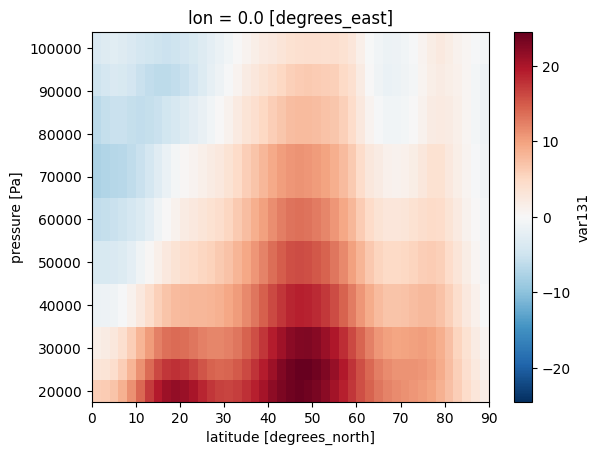

In [10]:
#Creo un dizionario in cui vado a mettere la media temporale per ogni stagione MAM, JJA, SON, DJF
era_seas_mean = {}
#Calcolo la media temporale su tutti e 4 i trimestri MAM = 1, JJA = 2, SON = 3, DJF = 4
for i in range(4):
    era_seas_mean[i+1] = compute_mean_resample_mar(dataset_ERA_zonavg,"1982","2014",i)
print(era_seas_mean.keys())
era_seas_mean[4].plot()


Bias zonal mean

In [11]:
for name in models_zonavg.keys():
    box = models_zonavg[name]['zonavg dataset']
    models_zonavg[name]['zonavg seasonal mean'] = None  # Inizializzo con un valore vuoto
    
    # Media temporale delle stagioni MAM, JJA, SON
    for i in range(4): # Ciclo su tutte le stagioni
        # Calcolo la media temporale per ogni stagione dei modelli

        if (i+1) == 4 : # DJF
            models_zonavg[name]['zonavg seasonal mean DJF'] = compute_mean_resample_mar(box["ua"],"1982","2014",i)
            model_seas_mean = models_zonavg[name]['zonavg seasonal mean DJF']
            model_seas_mean = model_seas_mean.assign_coords({"plev" : model_seas_mean.plev.round()}) # Per essere sicuri che i plev siano gli stessi
            models_zonavg[name]['zonavg bias DJF'] = model_seas_mean - era_seas_mean[i+1]

Plot del bias di tutti i modelli (relativo a ERA5, periodo 1982-2014 DJF)

In [12]:
#Creo una lista con il nome dei modelli
models_list_zonavg = list(models_zonavg.keys())

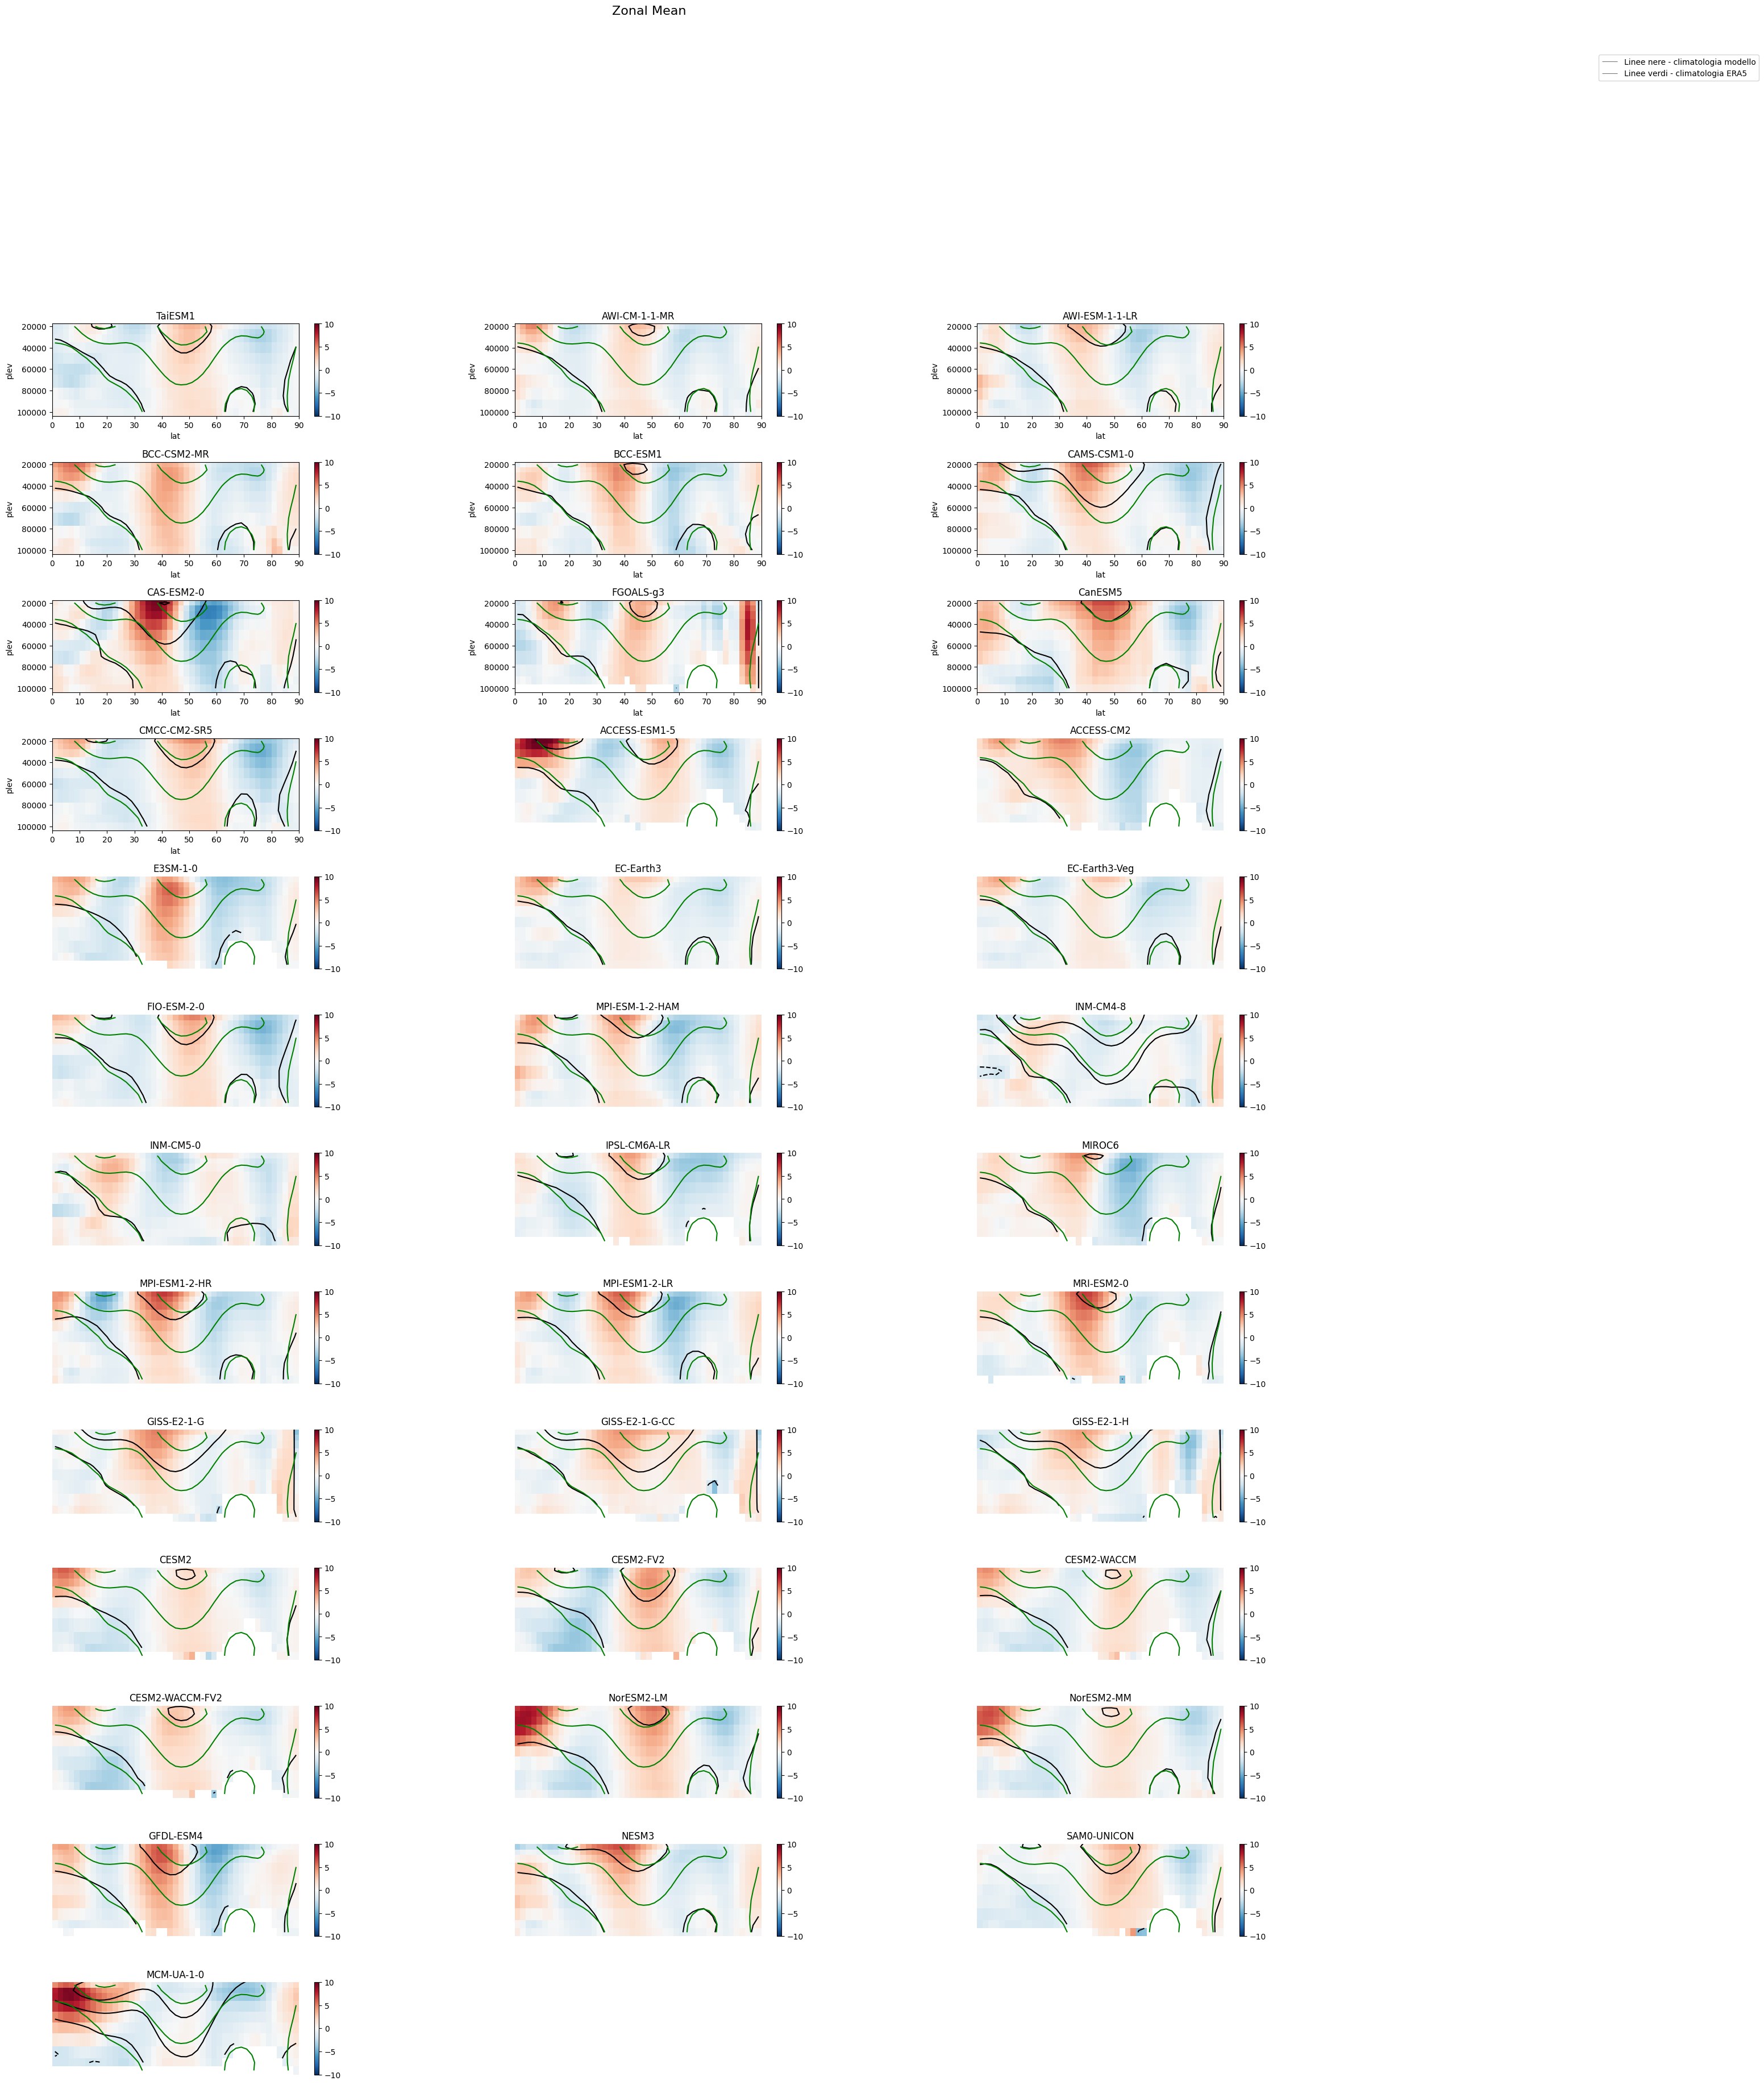

In [13]:
plot_zonavg((int(len(models_zonavg)/3)+1),3,(28,40),models_list_zonavg,models_zonavg,era_seas_mean,-10,10,'Zonal Mean','zonal_mean.pdf')

Plot delle medie zonali nei 5 cluster

Cluster 0

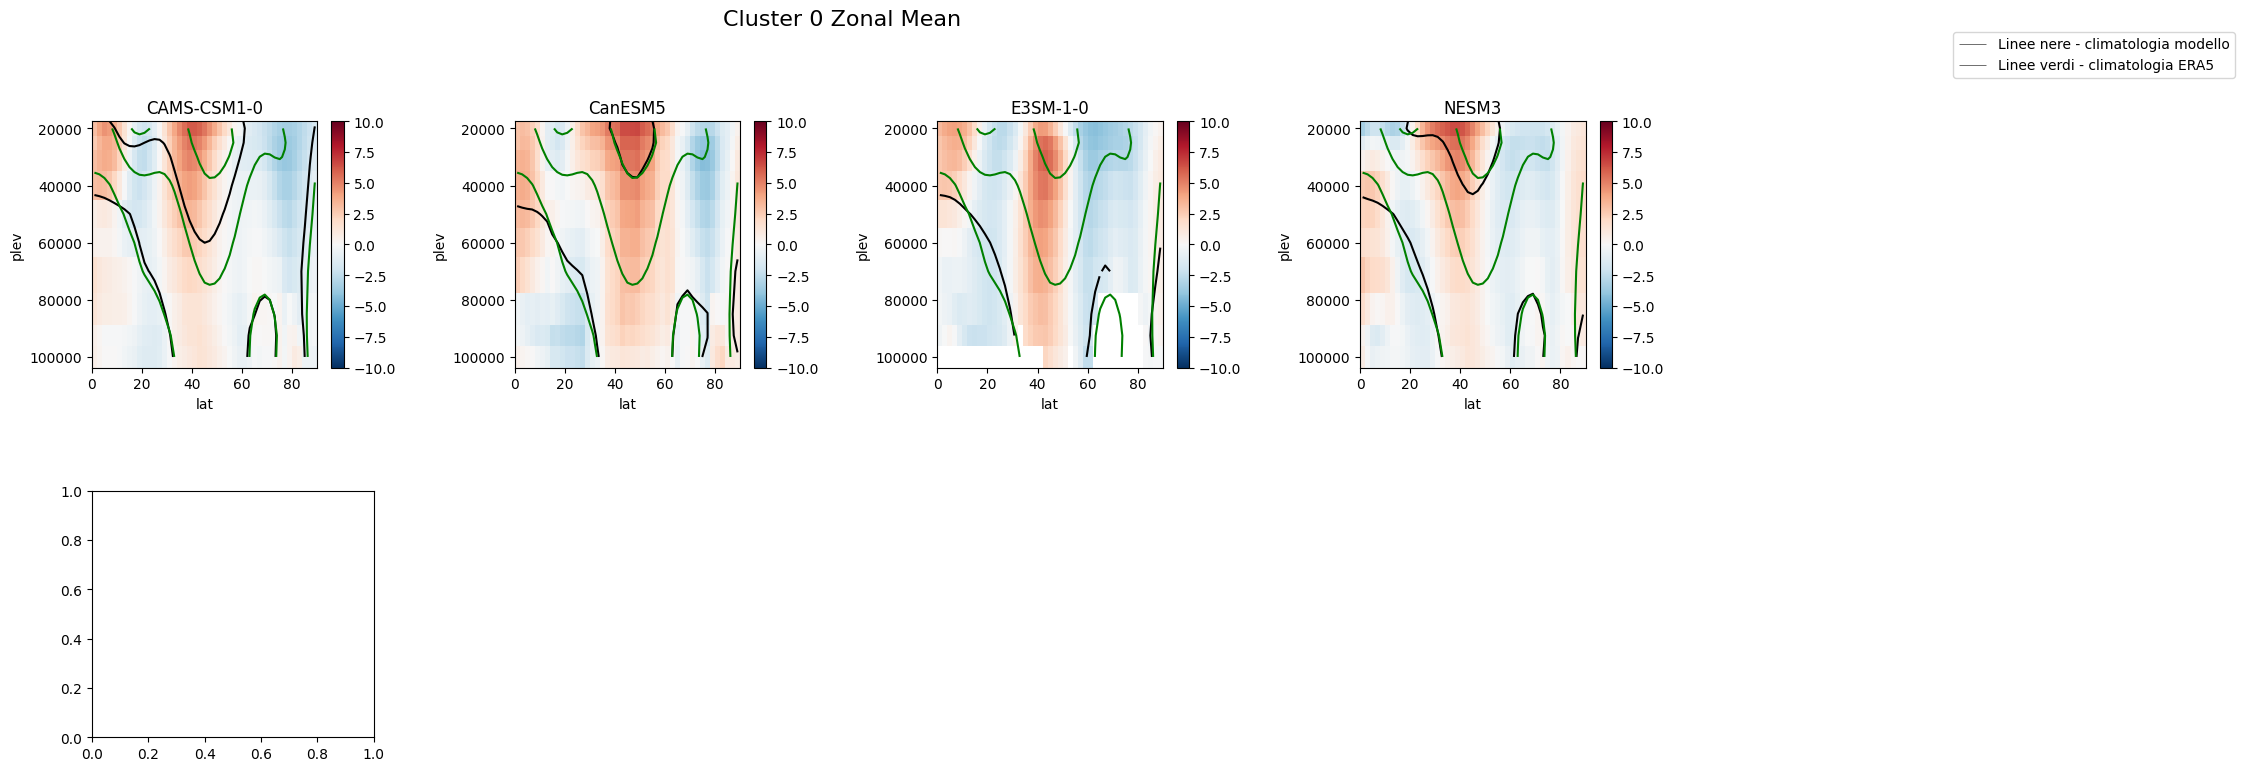

In [25]:
plot_zonavg(int(len(list_cluster0)/4)+1,4,(20,8),list_cluster0,models_zonavg,era_seas_mean,-10,10,'Cluster 0 Zonal Mean','zonavg_cluster0.pdf')

Cluster 1

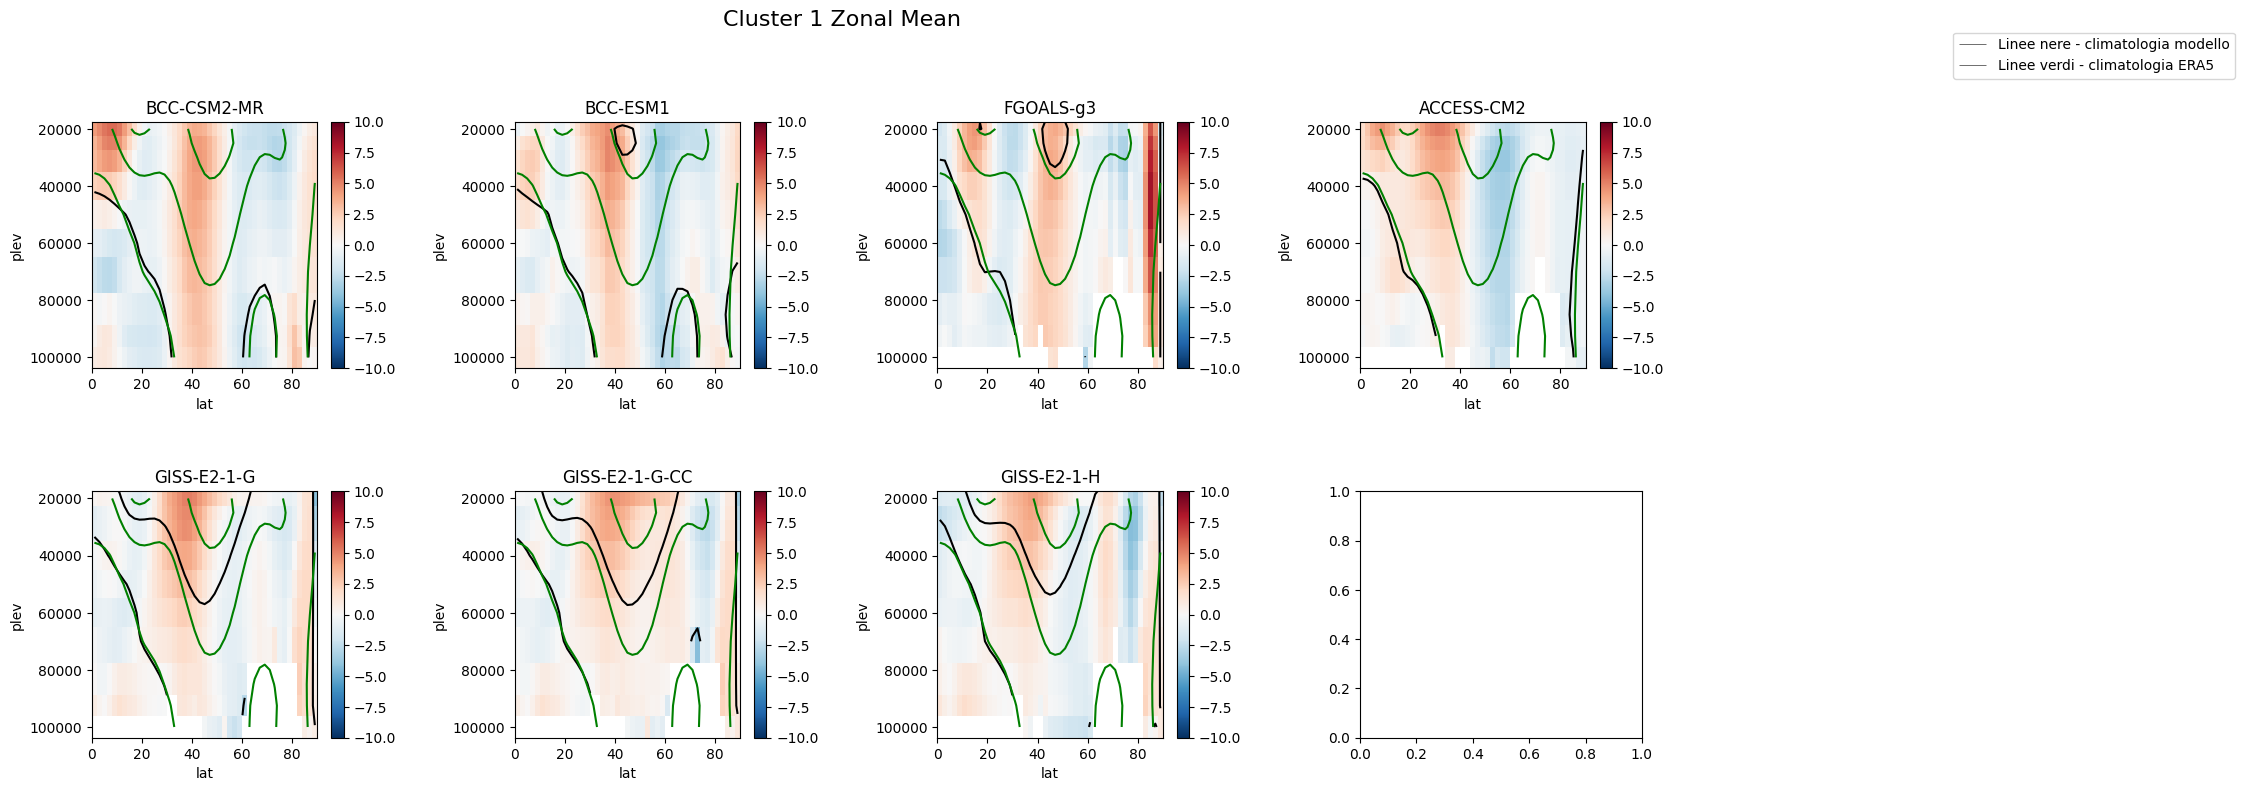

In [26]:
plot_zonavg(int(len(list_cluster1)/4)+1,4,(20,8),list_cluster1,models_zonavg,era_seas_mean,-10,10,'Cluster 1 Zonal Mean','zonavg_cluster1.pdf')

Cluster 2

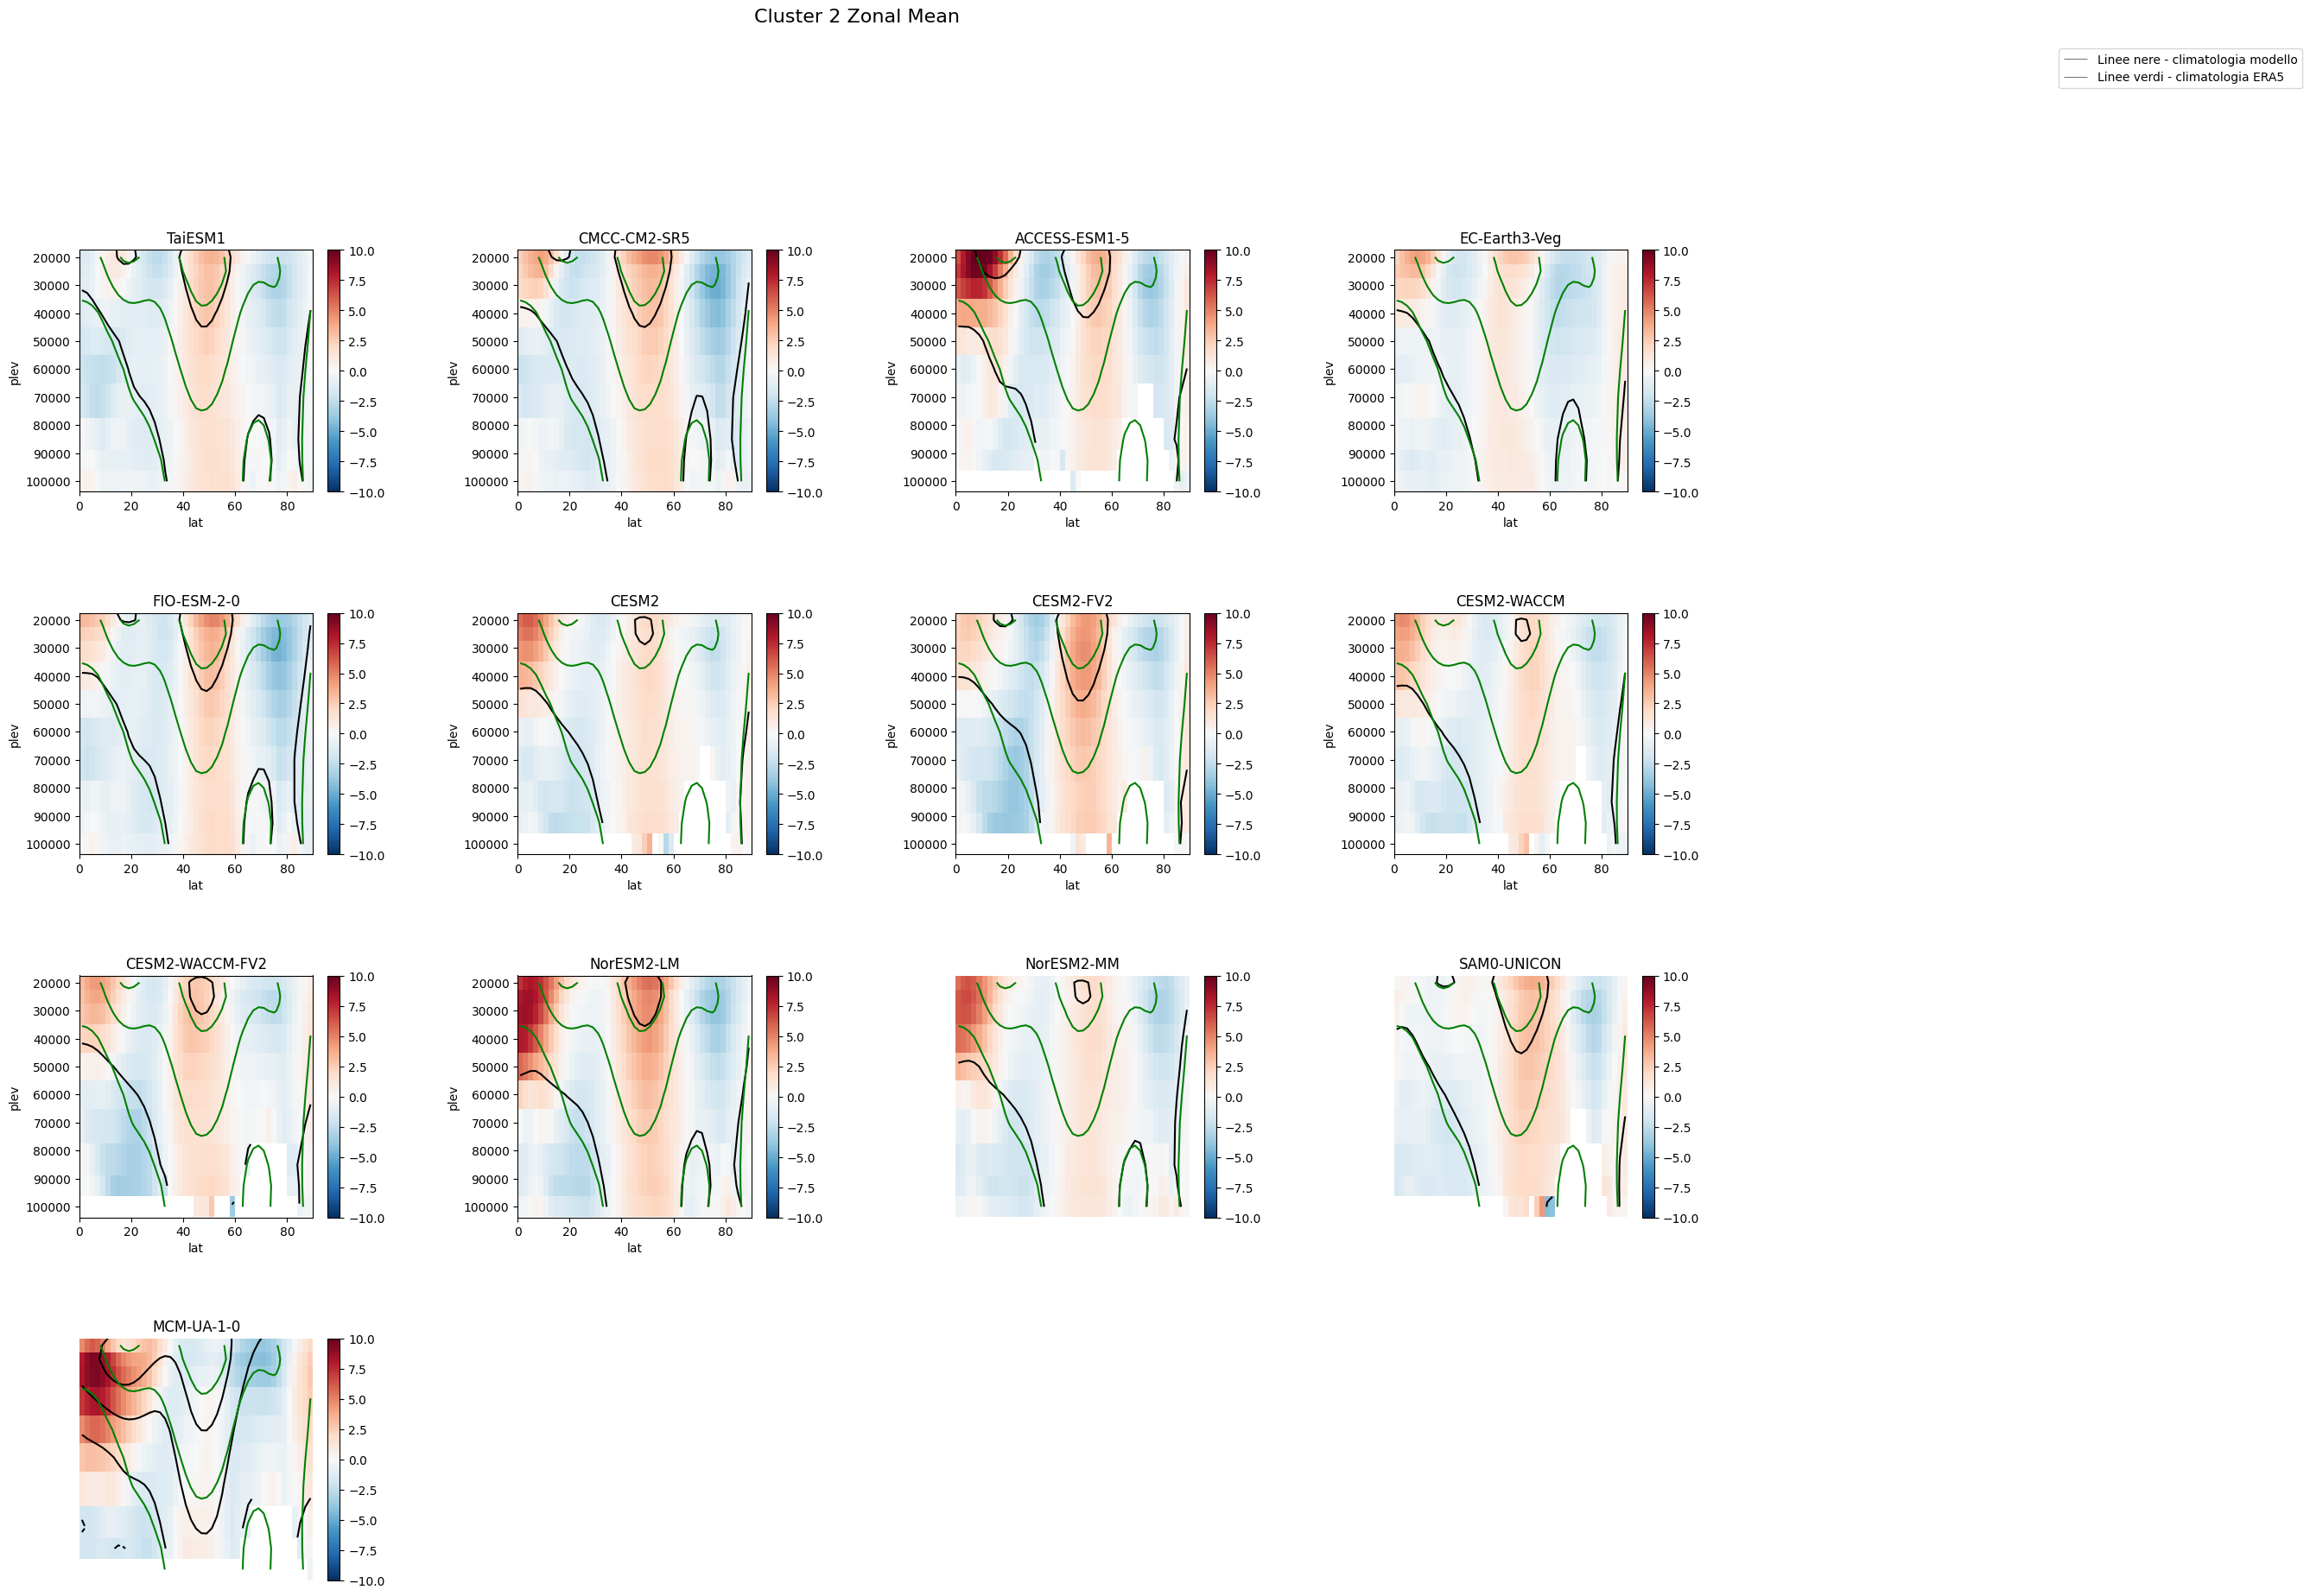

In [27]:
plot_zonavg(int(len(list_cluster2)/4)+1,4,(24,20),list_cluster2,models_zonavg,era_seas_mean,-10,10,'Cluster 2 Zonal Mean','zonavg_cluster2.pdf')

Cluster 3

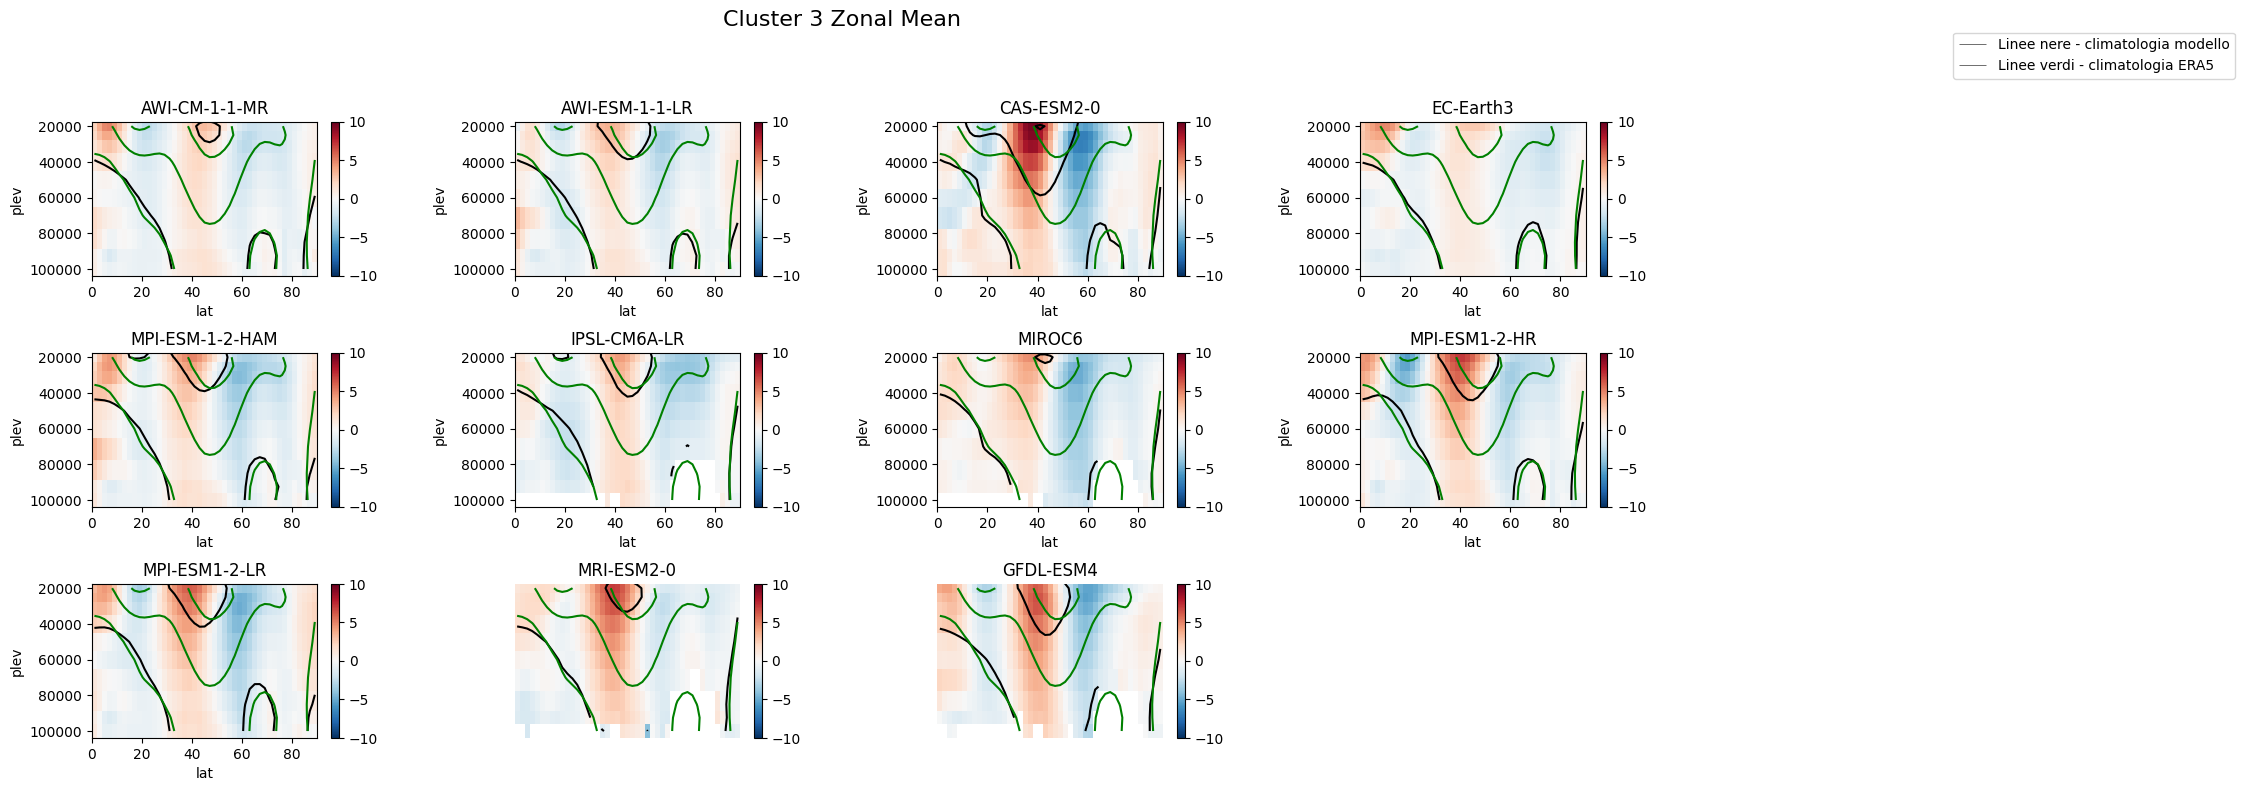

In [28]:
plot_zonavg(int(len(list_cluster3)/4)+1,4,(20,8),list_cluster3,models_zonavg,era_seas_mean,-10,10,'Cluster 3 Zonal Mean','zonavg_cluster3.pdf')

Cluster 4

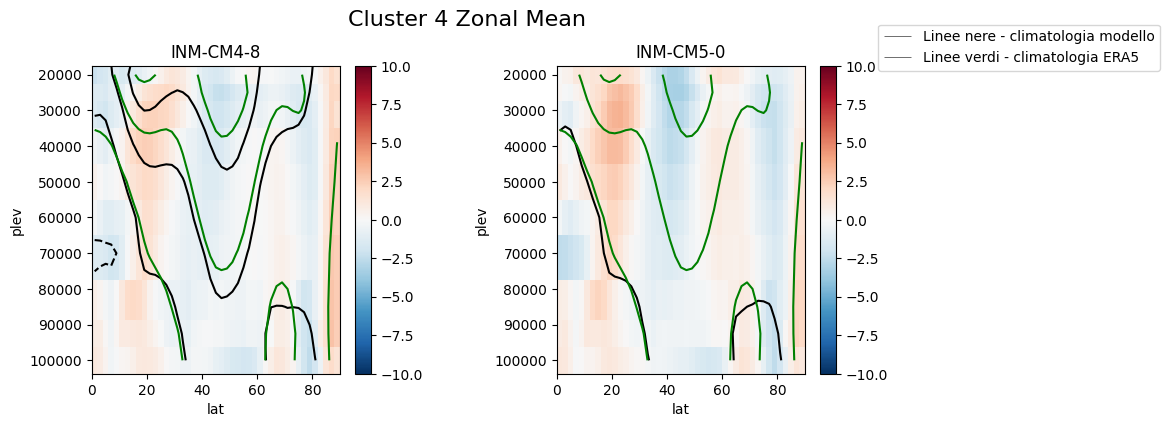

In [29]:
plot_zonavg_2_cluster((10,4),list_cluster4,models_zonavg,era_seas_mean,-10,10,'Cluster 4 Zonal Mean','zonavg_cluster4.pdf')

Plot dei cluster medi

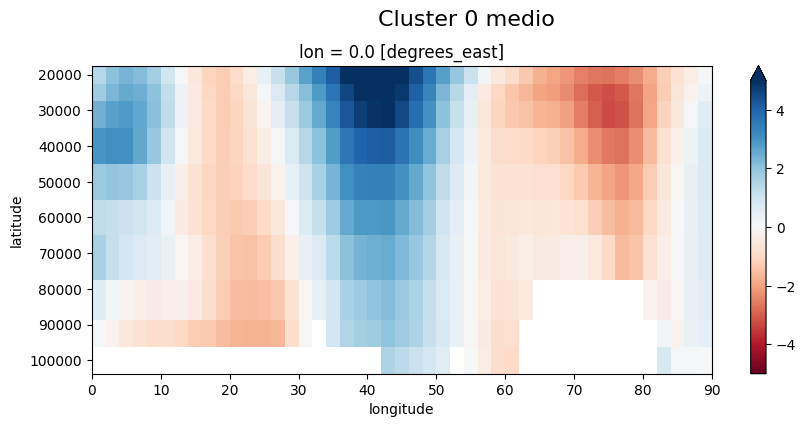

In [30]:
plot_mean_cluster_zonavg(len(list_cluster0),list_cluster0,models_zonavg,'Cluster 0 medio','zonavg_cluster0_mean.pdf',-5,5,(10,4))

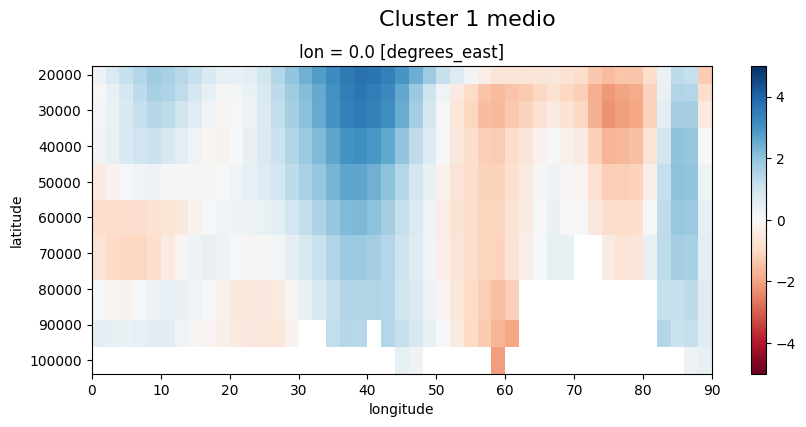

In [31]:
plot_mean_cluster_zonavg(len(list_cluster1),list_cluster1,models_zonavg,'Cluster 1 medio','zonavg_cluster1_mean.pdf',-5,5,(10,4))

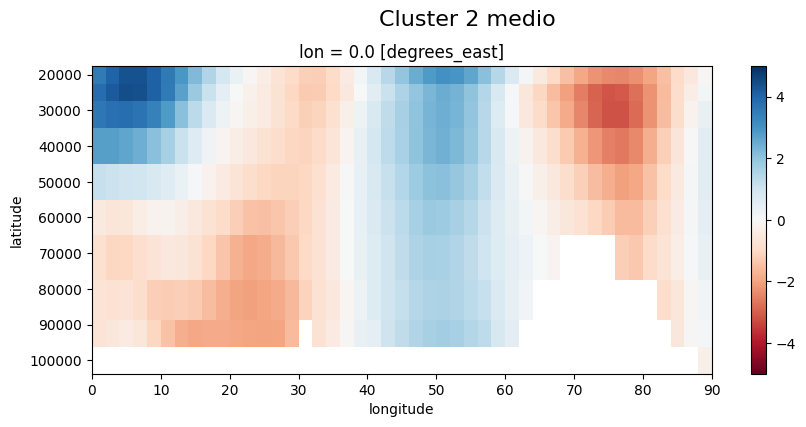

In [32]:
plot_mean_cluster_zonavg(len(list_cluster2),list_cluster2,models_zonavg,'Cluster 2 medio','zonavg_cluster2_mean.pdf',-5,5,(10,4))

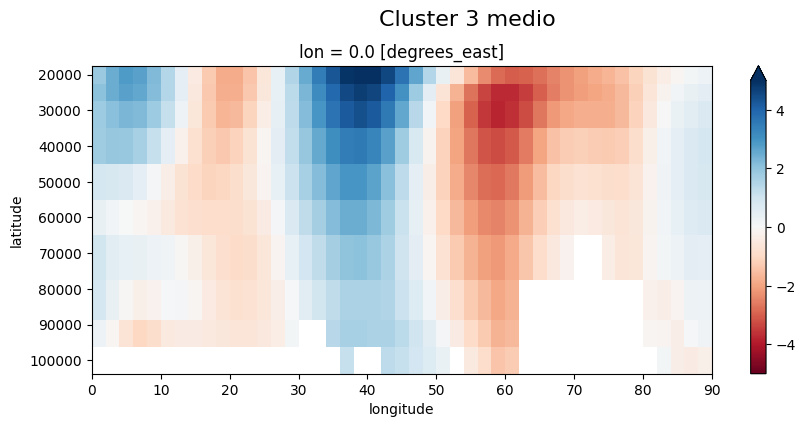

In [33]:
plot_mean_cluster_zonavg(len(list_cluster3),list_cluster3,models_zonavg,'Cluster 3 medio','zonavg_cluster3_mean.pdf',-5,5,(10,4))

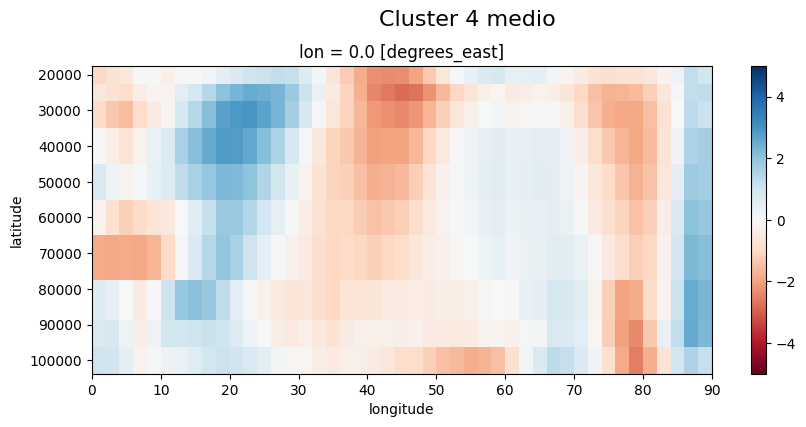

In [34]:
plot_mean_cluster_zonavg(len(list_cluster4),list_cluster4,models_zonavg,'Cluster 4 medio','zonavg_cluster4_mean.pdf',-5,5,(10,4))

Salvataggio in file pickle

In [35]:
# Salvataggio di models_zonavg
with open('models_zonavg.pkl', 'wb') as file:
    dill.dump(models_zonavg, file)
    dill.dump(era_seas_mean,file)
# Salvataggio liste e immagini pdf in un file Pickle
with open('modelli_zonavg.pickle', 'wb') as f: #'wb' = write binary
    pickle.dump(['zonavg_cluster0.pdf'], f) #salvataggio immagini modelli per ogni cluster
    pickle.dump(['zonavg_cluster1.pdf'], f)
    pickle.dump(['zonavg_cluster2.pdf'], f)
    pickle.dump(['zonavg_cluster3.pdf'], f)
    pickle.dump(['zonavg_cluster4.pdf'], f)    
    pickle.dump(['zonavg_cluster0_mean.pdf'], f) #salvataggio immagini cluster medio
    pickle.dump(['zonavg_cluster1_mean.pdf'], f)    
    pickle.dump(['zonavg_cluster2_mean.pdf'], f)    
    pickle.dump(['zonavg_cluster3_mean.pdf'], f)    
    pickle.dump(['zonavg_cluster4_mean.pdf'], f) 